In [13]:

library(ggplot2)
library(reshape2)
library(dplyr)
library(egg)
library(grid)
library(tidyverse)
library(ggExtra)
#BiocManager::install("clusterProfiler")
library(clusterProfiler)
#BiocManager::install("org.Sc.sgd.db")
library(org.Sc.sgd.db)
#library(sets)

In [16]:
VectorIntersect <- function(v,z) {
    unlist(lapply(unique(v[v%in%z]), function(x) rep(x,min(sum(v==x),sum(z==x)))))
}
is.contained <- function(v,z) {length(VectorIntersect(v,z))==length(v)}

In [4]:
data = read.csv("../Input/20230614_parsed_PPI_data.csv")

In [5]:
data = data %>% mutate(MaxPPI=pmax(PPI.Ortholog.GeneA,PPI.Ortholog.GeneB,PPI.Ortholog.Anc, na.rm = TRUE))
#data = data %>% rowwise() %>% mutate(SumPPI=sum(PPI.Ortholog.GeneA,PPI.Ortholog.GeneB,PPI.Ortholog.Anc, na.rm = TRUE))
data$AvePPI = rowMeans(data[,9:11], na.rm=TRUE)

#data = data %>% filter(AvePPI != "NaN")

data$RelPPI = data$AvePPI/data$PPI.Scer
data$RelPPIMax = data$MaxPPI/data$PPI.Scer
#unique(data$Ortholog.Species)
head(data)

,PPI_partner.Gene,PPI_partner.ORF,Ortholog.Species,State,PPI.NA,Ortholog.GeneA,Ortholog.GeneB,Ortholog.GeneAnc,PPI.Ortholog.GeneA,PPI.Ortholog.GeneB,PPI.Ortholog.Anc,PPI.A_div_B,PPI.Scer,PPI.Vehicle,MaxPPI,AvePPI,RelPPI,RelPPIMax
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,YLR027C,AAT2,T.delbrueckii,Anc,No,,,TDEL0E05230,NA,NA,51992.75,1.000000,10368.75,4043,51992.75,51992.75,5.014370,5.014370
2,YLR027C,AAT2,V.polyspora,AB,No,Kpol_1002.53,Kpol_1033.51,,29039.75,15932.00,NA,1.822731,10368.75,4043,29039.75,22485.88,2.168620,2.800699
3,YLR027C,AAT2,S.bayanusvar.uvarum,A,No,Suva_16.102,,,25431.25,NA,NA,25431.250000,10368.75,4043,25431.25,25431.25,2.452682,2.452682
4,YLR027C,AAT2,S.mikatae,A,No,Smik_6.409,,,10516.75,NA,NA,10516.750000,10368.75,4043,10516.75,10516.75,1.014274,1.014274
5,YLR027C,AAT2,S.kudriavzevii,A,No,Skud_16.75,,,10875.50,NA,NA,10875.500000,10368.75,4043,10875.50,10875.50,1.048873,1.048873
6,YLR027C,AAT2,K.africana,AB,No,KAFR0K00320,KAFR0C02290,,73575.50,31606.75,NA,2.327841,10368.75,4043,73575.50,52591.12,5.072080,7.095889


In [6]:
data_Ncas = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="N.castellii")
data_Ncas_ppi_A = data_Ncas %>% filter(PPI.Ortholog.GeneA > 10000)
data_Ncas_ppi_B = data_Ncas %>% filter(PPI.Ortholog.GeneB > 10000)

data_Kafr = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="K.africana")
data_Knag = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="K.naganishii")

data_Skud = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="S.kudriavzevii")
data_Tpha = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="T.phaffii")

data_Ndar = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="N.dairenensis")
data_Vpol = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="V.polyspora")

data_Tbla = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="T.blattae")

data_Scer = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="S.cerevisiae")
data_Scer_ppi = data_Scer %>% filter(MaxPPI > 10000)

In [24]:
species_list= c(
                    'T.delbrueckii',
                    'Z.rouxii' ,
                    'N.castellii',
                    'V.polyspora',
                    'K.africana' ,
                    'T.blattae'  ,
                    'N.dairenensis',
                    'K.naganishii',
                    'T.phaffii'   ,
                    'C.glabrata'  ,
                    'S.bayanusvar.uvarum' , 
                    'S.mikatae'           , 
                    'S.kudriavzevii'      ,
                    'S.cerevisiae'
)

In [8]:
species_dup_state = c(
                    'T.delbrueckii' = "Anc",
                    'Z.rouxii' = "Anc",
                    'N.castellii' = "AB",
                    'V.polyspora' = "AB",
                    'K.africana'  = "AB",
                    'T.blattae'   = "AB",
                    'N.dairenensis'="AB",
                    'K.naganishii'= "AB",
                    'T.phaffii'   = "AB",
                    'C.glabrata'          = "B",
                    'S.bayanusvar.uvarum' = "A", 
                    'S.mikatae'           = "A", 
                    'S.kudriavzevii'      = "A",
                    'S.cerevisiae'="A"
)

In [9]:
Scer = clusterProfiler::enrichGO(data_Scer_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
columns = c("ID","Description","geneID")

df_merged = data.frame(matrix(ncol = length(columns ), nrow = 0))
names(df_merged)= columns


In [ ]:
for (species in unique(data$Ortholog.Species) ){
     data_sp = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species==species)
    
   if (species %in% species_list) {
    species_dup = species_dup_state[[species]]
    
    if (species_dup == "Anc" ){
        sample = paste(species,species_dup,sep=".")
        
        data_ppi = data_sp %>% filter(PPI.Ortholog.Anc > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("../Ouput/GO_results/",sample,".csv",sep=""))
    }#IF Anc
       
    if (species_dup == "AB" ){
        sample = paste(species,"A",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneA > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("../Ouput/GO_results/",sample,".csv",sep=""))
        
        sample = paste(species,"B",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneB > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("../Ouput/GO_results/",sample,".csv",sep=""))
    }#IF AB
       
    if (species_dup == "A" ){
        sample = paste(species,"A",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneA > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("../Ouput/GO_results/",sample,".csv",sep=""))
    }#IF A
    if (species_dup == "B" ){
        sample = paste(species,"B",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneB > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("../Ouput/GO_results/",sample,".csv",sep=""))
    }#IF B
       
    
   }#IF in species_list
    }# FOR species

Warning message in file(file, ifelse(append, "a", "w")):
“ ファイル '../Ouput/GO_results/T.delbrueckii.Anc.csv' を開くことができません: No such file or directory ”


ERROR: Error in file(file, ifelse(append, "a", "w")):  コネクションを開くことができません 


In [ ]:
write.csv(df_merged,paste("../Output/Merged_GO_adjPval_results.csv",sep=""))


In [22]:
df_merged[is.na(df_merged)] <- 1

In [23]:
df_agg = df_merged %>% group_by(Description) %>%
  summarize(T.delbrueckii.Anc       = min(T.delbrueckii.Anc),
            Z.rouxii.Anc            = min(Z.rouxii.Anc),
            S.cerevisiae.A          = min(S.cerevisiae.A),
            S.bayanusvar.uvarum.A   = min(S.bayanusvar.uvarum.A),
            S.mikatae.A             = min(S.mikatae.A),
            S.kudriavzevii.A        = min(S.kudriavzevii.A),
            C.glabrata.B            = min(C.glabrata.B),
            N.castellii.A           = min(N.castellii.A),
            N.castellii.B           = min(N.castellii.B),
            V.polyspora.A           = min(V.polyspora.A),
            V.polyspora.B           = min(V.polyspora.B),
            K.africana.A            = min(K.africana.A),
            K.africana.B            = min(K.africana.B),
            T.blattae.A             = min(T.blattae.A),
            T.blattae.B             = min(T.blattae.B),
            N.dairenensis.A         = min(N.dairenensis.A),
            N.dairenensis.B         = min(N.dairenensis.B),
            K.naganishii.A          = min(K.naganishii.A),
            K.naganishii.B          = min(K.naganishii.B),
            T.phaffii.A             = min(T.phaffii.A),
            T.phaffii.B             = min(T.phaffii.B)
           )

In [27]:
df_agg_hmap = melt(df_agg,id.vars=c("Description"))
df_agg_hmap$variable = factor(df_agg_hmap$variable,levels=c("T.delbrueckii.Anc","Z.rouxii.Anc","S.cerevisiae.A","S.bayanusvar.uvarum.A","S.mikatae.A","S.kudriavzevii.A","C.glabrata.B","N.castellii.A","N.castellii.B","V.polyspora.A","V.polyspora.B","K.africana.A","K.africana.B","T.blattae.A","T.blattae.B","N.dairenensis.A","N.dairenensis.B","K.naganishii.A","K.naganishii.B","T.phaffii.A","T.phaffii.B"))
#unique(df_agg_hmap$Description)
#df_agg_hmap$Description = factor(df_agg_hmap$Description,levels=c())
names(df_agg_hmap)[2] ="Ortholog"
names(df_agg_hmap)[3] ="Adjusted.Pval"

In [35]:
write.csv(df_agg_hmap,"../Output/GO_aggregated_results_l.csv")
write.csv(df_agg,"../Output/GO_aggregated_results.csv")


,Description,Ortholog,Adjusted.Pval
,<chr>,<fct>,<dbl>
1,COPI-coated vesicle,T.delbrueckii.Anc,1.000000000
2,COPI-coated vesicle membrane,T.delbrueckii.Anc,0.045603710
3,Golgi apparatus,T.delbrueckii.Anc,1.000000000
4,Golgi membrane,T.delbrueckii.Anc,0.009772048
5,Golgi-associated vesicle,T.delbrueckii.Anc,1.000000000
6,Golgi-associated vesicle membrane,T.delbrueckii.Anc,0.013765544


In [14]:
df_agg_hmap = read.csv("../Output/GO_aggregated_results_l.csv")
df_agg = read.csv("../Output/GO_aggregated_results.csv")


In [15]:
# Elinimate GO terms (agggregated GO terms) is it is contained in another term.

go_members = read.csv("../Input/GO_member.csv")
head(go_members)



,Description,Members
,<chr>,<chr>
1,Golgi membrane,AKR1/COG1/COG3/COG4/COG6/KES1/RET2/SEC26
2,Golgi membrane,COG1/COG3/COG4/COG6
3,Golgi membrane,COG1/COG3/COG4/COG6/KES1/RET2/SEC26
4,cellular bud neck septin ring,CDC11/SHS1/SYP1
5,cellular bud neck septin structure,CDC11/NAP1/SHS1/SYP1
6,cellular bud neck septin structure,NAP1/SHS1/SYP1


In [16]:
member_dict = c()
for (row in 1:nrow(go_members)) {
    desc <- go_members[row, "Description"]
    memb <- as.list(strsplit(go_members[row, "Members"], '\\/'))[[1]]
    if ( desc %in% names(member_dict)){
        #print(desc)
        #print(length(member_dict[desc]))
        #print(memb)
        new = unique(c(member_dict[[desc]],memb))
        member_dict[[desc]] = new
    }else{
        member_dict[[desc]] = memb
    }
    }
member_dict

$`Golgi membrane`
[1] "AKR1"  "COG1"  "COG3"  "COG4"  "COG6"  "KES1"  "RET2"  "SEC26"

$`cellular bud neck septin ring`
[1] "CDC11" "SHS1"  "SYP1" 

$`cellular bud neck septin structure`
[1] "CDC11" "NAP1"  "SHS1"  "SYP1" 

$`P-body`
[1] "DCP2" "LSM3" "LSM6" "SSD1"

$`U6 snRNP`
[1] "LSM3" "LSM6"

$`Golgi apparatus`
[1] "CHC1"  "COG1"  "COG3"  "COG4"  "COG6"  "KES1"  "RET2"  "SEC26"

$`Golgi-associated vesicle`
[1] "CHC1"  "RET2"  "SEC26"

$polysome
[1] "NAM7" "SSA1" "SSB1"

$cytoskeleton
 [1] "AIM21" "ARC15" "ARC18" "ARC35" "ARC40" "CDC11" "CHC1"  "END3"  "HRR25"
[10] "LAS17" "MYO5"  "NAP1"  "PAN1"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SRV2" 
[19] "SYP1"  "TPM2"  "VRP1"  "MYO2"  "CAP2"  "MYO3" 

$`actin filament`
[1] "MYO2" "SAC6" "TPM2"

$`cellular bud`
 [1] "CAP2"  "MYO5"  "NAP1"  "PAN1"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SMI1" 
[10] "SSD1"  "SYP1"  "TCB3"  "TPM2"  "VRP1"  "CDC11" "HRR25" "PEX30" "MYO2" 

$`cellular bud neck`
 [1] "CDC11" "HRR25" "NAP1"  "PAN1"  "SHS1"  "SLA1"  "SLA2"  "SMI1"  "SSD1" 
[10] "SYP1"  "TPM2"  "VRP1"  "MYO2" 

$`mating projection`
 [1] "AIM21" "CAR1"  "CDC11" "END3"  "LAS17" "MID2"  "MYO5"  "PAN1"  "SAC6" 
[10] "SHS1"  "SLA1"  "SLA2"  "SMI1"  "SRV2"  "SYP1"  "VRP1"  "MYO2"  "CAP2" 
[19] "SFB3" 

$`cell cortex`
 [1] "AIM21" "ARC15" "ARC35" "ARC40" "CDC11" "CHC1"  "END3"  "LAS17" "MYO5" 
[10] "NAP1"  "PAN1"  "RTN2"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SRV2"  "SYP1" 
[19] "TCB3"  "TPM2"  "VRP1"  "CAP2"  "MYO3" 

$`septin ring`
[1] "CDC11" "SHS1"  "SYP1" 

$`vesicle membrane`
[1] "AKR1"  "CHC1"  "END3"  "MEH1"  "PAN1"  "RET2"  "SEC26" "SLA1"  "SFB3" 

$`actin cytoskeleton`
 [1] "AIM21" "ARC15" "ARC18" "ARC35" "ARC40" "CHC1"  "END3"  "LAS17" "MYO5" 
[10] "PAN1"  "SAC6"  "SLA1"  "SLA2"  "SRV2"  "TPM2"  "VRP1"  "MYO2"  "CAP2" 
[19] "MYO3" 

$`proton-transporting two-sector ATPase complex`
[1] "VMA7" "VMA8"

$`vacuolar proton-transporting V-type ATPase complex`
[1] "VMA7" "VMA8"

$`membrane coat`
[1] "CHC1"  "RET2"  "SEC26" "SFB3" 

$`vesicle coat`
[1] "CHC1"  "RET2"  "SEC26" "SFB3" 

$`coated vesicle`
[1] "CHC1"  "RET2"  "SEC26" "SLA2"  "SFB3" 

$`clathrin-coated vesicle`
[1] "CHC1" "SLA2"

$`COPI-coated vesicle`
[1] "RET2"  "SEC26"

$`site of polarized growth`
 [1] "AIM21" "CAR1"  "CDC11" "END3"  "HRR25" "LAS17" "MID2"  "MYO5"  "NAP1" 
[10] "PAN1"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SMI1"  "SRV2"  "SSD1"  "SYP1" 
[19] "TPM2"  "VRP1"  "MYO2"  "CAP2"  "SFB3" 

$`actin cortical patch`
 [1] "AIM21" "ARC15" "ARC35" "ARC40" "CHC1"  "END3"  "LAS17" "MYO5"  "PAN1" 
[10] "SAC6"  "SLA1"  "SLA2"  "SRV2"  "VRP1"  "CAP2"  "MYO3" 

$`transport vesicle membrane`
[1] "CHC1" "SFB3"

$`cytoplasmic vesicle membrane`
[1] "AKR1"  "CHC1"  "END3"  "MEH1"  "PAN1"  "RET2"  "SEC26" "SLA1"  "SFB3" 

$`Golgi-associated vesicle membrane`
[1] "CHC1"  "RET2"  "SEC26"

$`coated vesicle membrane`
[1] "CHC1"  "RET2"  "SEC26"

$`COPI-coated vesicle membrane`
[1] "RET2"  "SEC26"

$`cortical cytoskeleton`
 [1] "AIM21" "ARC15" "ARC35" "ARC40" "CHC1"  "END3"  "LAS17" "MYO5"  "PAN1" 
[10] "SAC6"  "SLA1"  "SLA2"  "SRV2"  "TPM2"  "VRP1"  "CAP2"  "MYO3" 

$`cortical actin cytoskeleton`
 [1] "AIM21" "ARC15" "ARC35" "ARC40" "CHC1"  "END3"  "LAS17" "MYO5"  "PAN1" 
[10] "SAC6"  "SLA1"  "SLA2"  "SRV2"  "TPM2"  "VRP1"  "CAP2"  "MYO3" 

$`cytoplasmic vesicle`
 [1] "AKR1"  "CHC1"  "END3"  "MEH1"  "PAN1"  "RET2"  "SEC26" "SLA1"  "SLA2" 
[10] "SYP1"  "VPS35" "MYO2" 

$vesicle
 [1] "AKR1"  "CHC1"  "END3"  "MEH1"  "MYO3"  "MYO5"  "PAN1"  "RET2"  "SEC26"
[10] "SLA1"  "SLA2"  "SYP1"  "VPS35" "MYO2" 

$`cell division site`
[1] "CDC11" "NAP1"  "SHS1"  "SYP1"  "TPM2" 

$`septin cytoskeleton`
[1] "CDC11" "NAP1"  "SHS1"  "SYP1" 

$`cleavage apparatus septin structure`
[1] "CDC11" "NAP1"  "SHS1"  "SYP1" 

$`proton-transporting V-type ATPase complex`
[1] "VMA7" "VMA8"

$`ribonucleoprotein granule`
[1] "DCP2" "LSM3" "LSM6" "SSD1"

$`cytoplasmic ribonucleoprotein granule`
[1] "DCP2" "LSM3" "LSM6" "SSD1"

$`cell projection`
 [1] "AIM21" "CAR1"  "CDC11" "END3"  "LAS17" "MID2"  "

In [37]:
counts = c()
del_l = c()
for (term in names(member_dict)){
members =  member_dict[[term]]
counts[term] =  length(members)    
}
counts = counts[order(unlist(counts))]


for (i in seq(1,length(counts))){
    
term   = names(counts[i])
    
member =  member_dict[[term]]


for (j in seq(i+1,length(counts))){
    
term2   = names(counts[j])
member2 =   member_dict[[term2]]

    
    
if(is.contained(member, member2) ==TRUE  ){

del_l = c(del_l,term)

}
    }
}


In [38]:
unique(del_l)

[1] "U6 snRNP"                                          
 [2] "proton-transporting two-sector ATPase complex"     
 [3] "vacuolar proton-transporting V-type ATPase complex"
 [4] "clathrin-coated vesicle"                           
 [5] "COPI-coated vesicle"                               
 [6] "transport vesicle membrane"                        
 [7] "COPI-coated vesicle membrane"                      
 [8] "U4/U6 x U5 tri-snRNP complex"                      
 [9] "spliceosomal tri-snRNP complex"                    
[10] "side of membrane"                                  
[11] "cellular bud neck septin ring"                     
[12] "Golgi-associated vesicle"                          
[13] "actin filament"                                    
[14] "septin ring"                                       
[15] "Golgi-associated vesicle membrane"                 
[16] "coated vesicle membrane"                           
[17] "cellular bud neck septin structure"                
[18] "P-body"                                            
[19] "membrane coat"                                     
[20] "vesicle coat"                                      
[21] "septin cytoskeleton"                               
[22] "cleavage apparatus septin structure"               
[23] "ribonucleoprotein granule"                         
[24] "coated membrane"                                   
[25] "vesicle tethering complex"                         
[26] "cell division site"                                
[27] "membrane raft"                                     
[28] "vesicle membrane"                                  
[29] "cytoplasmic vesicle"                               
[30] "intracellular vesicle"                             
[31] "cellular bud neck"                                 
[32] "actin cortical patch"                              
[33] "cortical cytoskeleton"                             
[34] "cortical actin cytoskeleton"                       
[35] "endocytic patch"                                   
[36] "mating projection"                                 
[37] "actin cytoskeleton"                                
[38] "mating projection tip"                             
[39] "cell projection"                                   
[40] "cell tip"                                          
[41] "cell pole"                                         
[42] "cytoskeleton"

In [39]:
for (redundunt_terms in unique(del_l)){
member_dict[[redundunt_terms]] = NULL
}

member_dict

$`Golgi membrane`
[1] "AKR1"  "COG1"  "COG3"  "COG4"  "COG6"  "KES1"  "RET2"  "SEC26"

$`Golgi apparatus`
[1] "CHC1"  "COG1"  "COG3"  "COG4"  "COG6"  "KES1"  "RET2"  "SEC26"

$polysome
[1] "NAM7" "SSA1" "SSB1"

$`cellular bud`
 [1] "CAP2"  "MYO5"  "NAP1"  "PAN1"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SMI1" 
[10] "SSD1"  "SYP1"  "TCB3"  "TPM2"  "VRP1"  "CDC11" "HRR25" "PEX30" "MYO2" 

$`cell cortex`
 [1] "AIM21" "ARC15" "ARC35" "ARC40" "CDC11" "CHC1"  "END3"  "LAS17" "MYO5" 
[10] "NAP1"  "PAN1"  "RTN2"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SRV2"  "SYP1" 
[19] "TCB3"  "TPM2"  "VRP1"  "CAP2"  "MYO3" 

$`coated vesicle`
[1] "CHC1"  "RET2"  "SEC26" "SLA2"  "SFB3" 

$`site of polarized growth`
 [1] "AIM21" "CAR1"  "CDC11" "END3"  "HRR25" "LAS17" "MID2"  "MYO5"  "NAP1" 
[10] "PAN1"  "SAC6"  "SHS1"  "SLA1"  "SLA2"  "SMI1"  "SRV2"  "SSD1"  "SYP1" 
[19] "TPM2"  "VRP1"  "MYO2"  "CAP2"  "SFB3" 

$`cytoplasmic vesicle membrane`
[1] "AKR1"  "CHC1"  "END3"  "MEH1"  "PAN1"  "RET2"  "SEC26" "SLA1"  "SFB3" 

$vesicle
 [1] "AKR1"  "CHC1"  "END3"  "MEH1"  "MYO3"  "MYO5"  "PAN1"  "RET2"  "SEC26"
[10] "SLA1"  "SLA2"  "SYP1"  "VPS35" "MYO2" 

$`proton-transporting V-type ATPase complex`
[1] "VMA7" "VMA8"

$`cytoplasmic ribonucleoprotein granule`
[1] "DCP2" "LSM3" "LSM6" "SSD1"

$`cytoplasmic side of membrane`
[1] "DCP2" "GPA2"

$`plasma membrane protein complex`
[1] "CHC1" "GPA2"

$`membrane microdomain`
[1] "MEH1" "PST2" "RFS1" "VAC8" "VMA8"

$`plasma membrane bounded cell projection`
 [1] "AIM21" "CAR1"  "CDC11" "END3"  "LAS17" "MID2"  "MYO5"  "PAN1"  "SAC6" 
[10] "SHS1"  "SLA1"  "SLA2"  "SMI1"  "SRV2"  "SYP1"  "VRP1"  "MYO2"  "CAP2" 
[19] "MYO3"  "SFB3"

In [40]:
names(member_dict)

[1] "Golgi membrane"                           
 [2] "Golgi apparatus"                          
 [3] "polysome"                                 
 [4] "cellular bud"                             
 [5] "cell cortex"                              
 [6] "coated vesicle"                           
 [7] "site of polarized growth"                 
 [8] "cytoplasmic vesicle membrane"             
 [9] "vesicle"                                  
[10] "proton-transporting V-type ATPase complex"
[11] "cytoplasmic ribonucleoprotein granule"    
[12] "cytoplasmic side of membrane"             
[13] "plasma membrane protein complex"          
[14] "membrane microdomain"                     
[15] "plasma membrane bounded cell projection"

In [17]:
gos = c(
"cortical cytoskeleton",
"cellular bud",
"endocytic patch",
"plasma membrane bounded cell projection",
"cytoplasmic vesicle membrane",
"membrane microdomain",
"vesicle",
"proton-transporting V-type ATPase complex",
"ribonucleoprotein granule"

)


In [18]:
df_agg_hmap2 = df_agg_hmap %>% filter(Description %in% gos)
#head(df_agg_hmap2)
df_agg_hmap2$Description = factor(df_agg_hmap2$Description,levels=gos)

In [28]:
species_order= c(
                    'T.delbrueckii.Anc',
                    'Z.rouxii.Anc' ,
    'S.cerevisiae.A',
    'S.bayanusvar.uvarum.A' , 
    'S.mikatae.A'           , 
    'S.kudriavzevii.A'      ,
    'C.glabrata.B'  ,                    
        'N.castellii.A',
        'N.castellii.B',
        'V.polyspora.A',
        'V.polyspora.B',
        'K.africana.A' ,
        'K.africana.B' ,
        'T.blattae.A'  ,
        'T.blattae.B'  ,
        'N.dairenensis.A',
        'N.dairenensis.B',
        'K.naganishii.A',
        'K.naganishii.B',
        'T.phaffii.A'   ,
        'T.phaffii.B'             
)

In [29]:
unique(df_agg_hmap2$Ortholog)

[1] "T.delbrueckii.Anc"     "Z.rouxii.Anc"          "S.cerevisiae.A"       
 [4] "S.bayanusvar.uvarum.A" "S.mikatae.A"           "S.kudriavzevii.A"     
 [7] "C.glabrata.B"          "N.castellii.A"         "N.castellii.B"        
[10] "V.polyspora.A"         "V.polyspora.B"         "K.africana.A"         
[13] "K.africana.B"          "T.blattae.A"           "T.blattae.B"          
[16] "N.dairenensis.A"       "N.dairenensis.B"       "K.naganishii.A"       
[19] "K.naganishii.B"        "T.phaffii.A"           "T.phaffii.B"

In [30]:
df_agg_hmap2$Ortholog = factor(df_agg_hmap2$Ortholog,levels=species_order)

In [31]:
head(df_agg_hmap2)

,X,Description,Ortholog,Adjusted.Pval
,<int>,<fct>,<fct>,<dbl>
1,18,cellular bud,T.delbrueckii.Anc,1.298363e-04
2,28,cortical cytoskeleton,T.delbrueckii.Anc,2.299080e-12
3,32,cytoplasmic vesicle membrane,T.delbrueckii.Anc,9.772048e-03
4,34,endocytic patch,T.delbrueckii.Anc,2.248526e-13
5,39,membrane microdomain,T.delbrueckii.Anc,2.341784e-03
6,41,plasma membrane bounded cell projection,T.delbrueckii.Anc,6.428289e-09


In [32]:
Y = length(unique(df_agg_hmap2$Description))
X = length(unique(df_agg_hmap2$Ortholog))


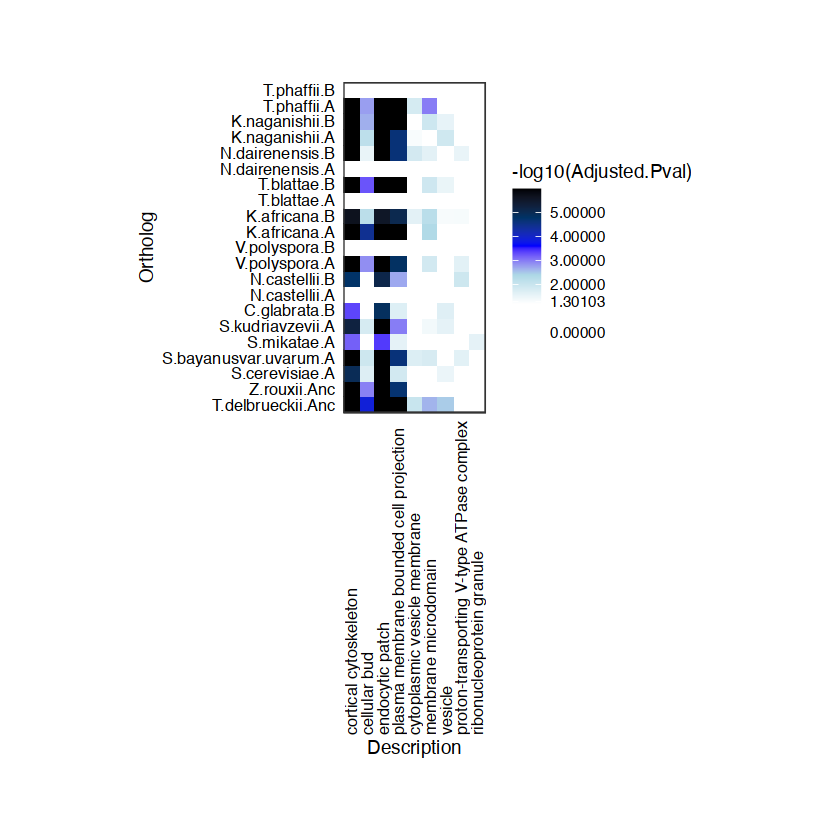

In [37]:
heatmap  =  ggplot(df_agg_hmap2 )+   
            geom_tile(aes(x=Description,y=Ortholog,fill = -log10(Adjusted.Pval)))  + 
            theme_bw()   + 
            theme(legend.position='right',
                  legend.key = element_blank(), 
                  strip.background = element_rect(colour="#FFFFFF", color="#FFFFFF",fill="#FFFFFF"),
                  panel.grid.minor = element_blank(),
                  panel.grid.major = element_blank(),
                  panel.background = element_blank(),
                  axis.ticks = element_blank(),
                  axis.text.x = element_text(size=9.5,color="#000000",angle=90,hjust=0,vjust=0.5),
                  axis.text.y = element_text(size=9.5,color="#000000")#element_blank()
                 )+ 
            scale_x_discrete(expand=c(0,0)) + 
            scale_y_discrete(expand=c(0,0)) +
            scale_fill_gradientn(colors=c("#FFFFFF","#FFFFFF","#ADD8E6","#0000FF","#003366","#000000"),breaks=c(0,-log10(0.05),-log10(0.01),-log10(0.001),-log10(0.0001),-log10(0.00001)),limits=c(0,6),na.value="#000000")+
             scale_colour_continuous(guide = guide_legend(direction = "vertical", title.position = "left",
                             label.position="right", label.hjust = 0.5, label.vjust = 0.5,
                             label.theme = element_text(angle = 90)))

p <- set_panel_size(heatmap,width  = unit(3, "cm"),height = unit(7, "cm"))
grid.newpage()
grid.draw(p) 
ggsave(plot=p,"../Output/heatmap_GO_chosen_revise.pdf",width  = unit(10, "cm"),height = unit(9, "cm"))